### Import Libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")


In [2]:
import hydra
from hydra import initialize, compose

import torch
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import ModelSummary, ModelCheckpoint


In [3]:
from src.models.unet import UNet
from src.data.unet_data import OxfordPetDataModule
from src.utils.unet_transforms import image_transforms, mask_transforms
from src.utils.initialize import create_dirs
from src.utils.plotting import plot_unet_samples, plot_unet_results


### Load Config

In [4]:
try:
    initialize(version_base="1.3", config_path=".", job_name="all")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base="1.3", config_path=".", job_name="all")

In [5]:
cfg = compose(config_name="config")


### Create Required Directories

In [6]:
create_dirs(
    [
        cfg.root.data_path,
        cfg.root.models,
        cfg.root.logs,
        cfg.unet.data,
        cfg.unet.models,
        cfg.unet.logs,
    ],
    ".",
)

### Load the Data

In [7]:
datamodule = OxfordPetDataModule(
    path=cfg.unet.data,
    transforms=image_transforms,
    mask_transforms=mask_transforms,
    batch_size=cfg.unet.batch_size,
)
datamodule.setup()

### Plot Sample Images

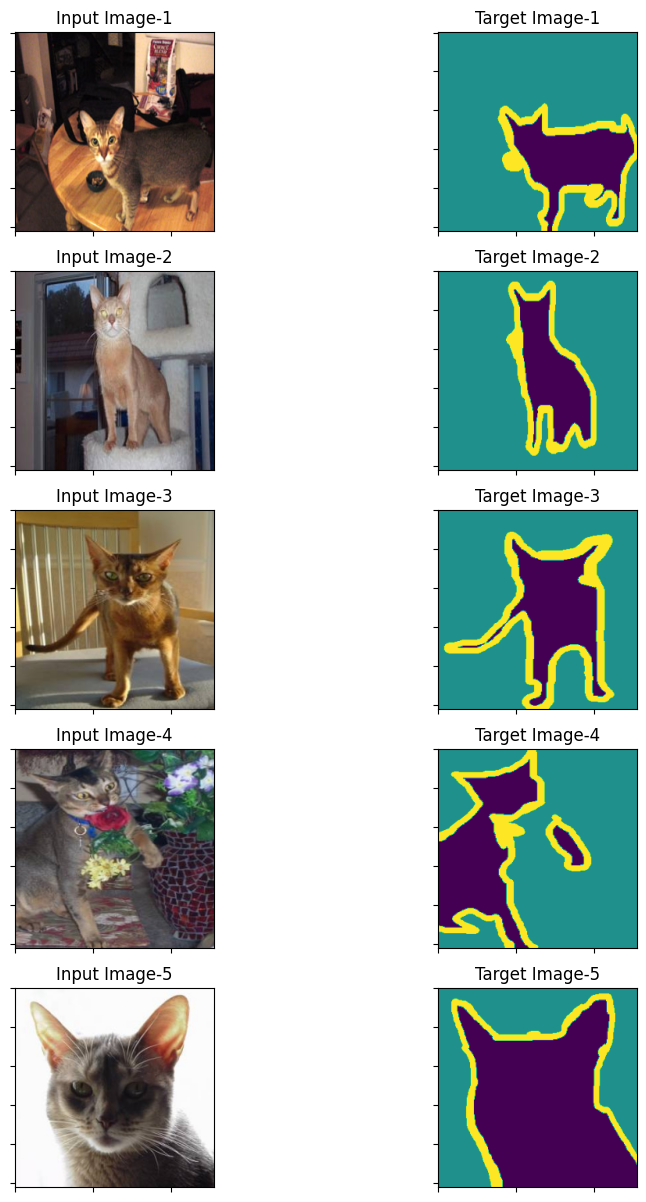

In [8]:
plot_unet_samples(datamodule=datamodule,
                  num_images=5)


### MaxPool + TransposeConv + BCE

In [9]:
model = UNet(
    in_channels=3,
    out_channels=1,
    lr=cfg.unet.lr,
    maxlr=cfg.unet.lr,
    epochs=cfg.unet.epochs,
    scheduler_steps = len(datamodule.train_dataloader()),
    loss="bce",
    contraction_mode="strconv",
    expansion_mode="transpose",
)


In [10]:
callbacks = [
    ModelSummary(max_depth=3),
    ModelCheckpoint(
        dirpath=f"{cfg.unet.models}/strconv_tr_bce",
        filename="tr_{epoch}",
        monitor="train_loss",
        mode="min",
        save_last=True,
    ),
]

In [11]:
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    num_nodes=1,
    max_epochs=cfg.unet.epochs,
    callbacks=callbacks,
    check_val_every_n_epoch=cfg.unet.epochs,
)


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Find the best learning rate

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at /home/ravi.naik/learning/era/s18/.lr_find_8a79ec2b-8105-455a-84cb-c30cc32ac2c2.ckpt
Restored all states from the checkpoint at /home/ravi.naik/learning/era/s18/.lr_find_8a79ec2b-8105-455a-84cb-c30cc32ac2c2.ckpt


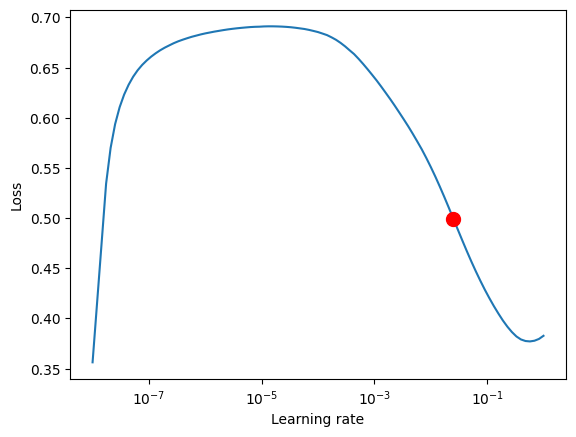

In [12]:
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(model=model, datamodule=datamodule)
maxlr = lr_finder.suggestion()
fig = lr_finder.plot(suggest=True)

### Update Optimum LR & Train Model

In [13]:
model.lr = maxlr
model.maxlr = maxlr
trainer.fit(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                   | Type             | Params
-------------------------------------------------------------
0  | contract1              | ContractingBlock | 55.4 K
1  | contract1.conv_block   | Sequential       | 39.0 K
2  | contract1.conv_block.0 | Conv2d           | 1.8 K 
3  | contract1.conv_block.1 | BatchNorm2d      | 128   
4  | contract1.conv_block.2 | ReLU             | 0     
5  | contract1.conv_block.3 | Conv2d           | 36.9 K
6  | contract1.conv_block.4 | BatchNorm2d      | 128   
7  | contract1.conv_block.5 | ReLU             | 0     
8  | contract1.downsample   | Conv2d           | 16.4 K
9  | contract2              | ContractingBlock | 287 K 
10 | contract2.conv_block   | Sequential       | 221 K 
11 | contract2.conv_block.0 | Conv2d           | 73.9 K
12 | contract2.conv_block.1 | BatchNorm2d      | 256   
13 | contract2.conv_block.2 | ReLU             | 0     
14 | contract2.conv_block.3 | Conv2d           | 147 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### Check Results

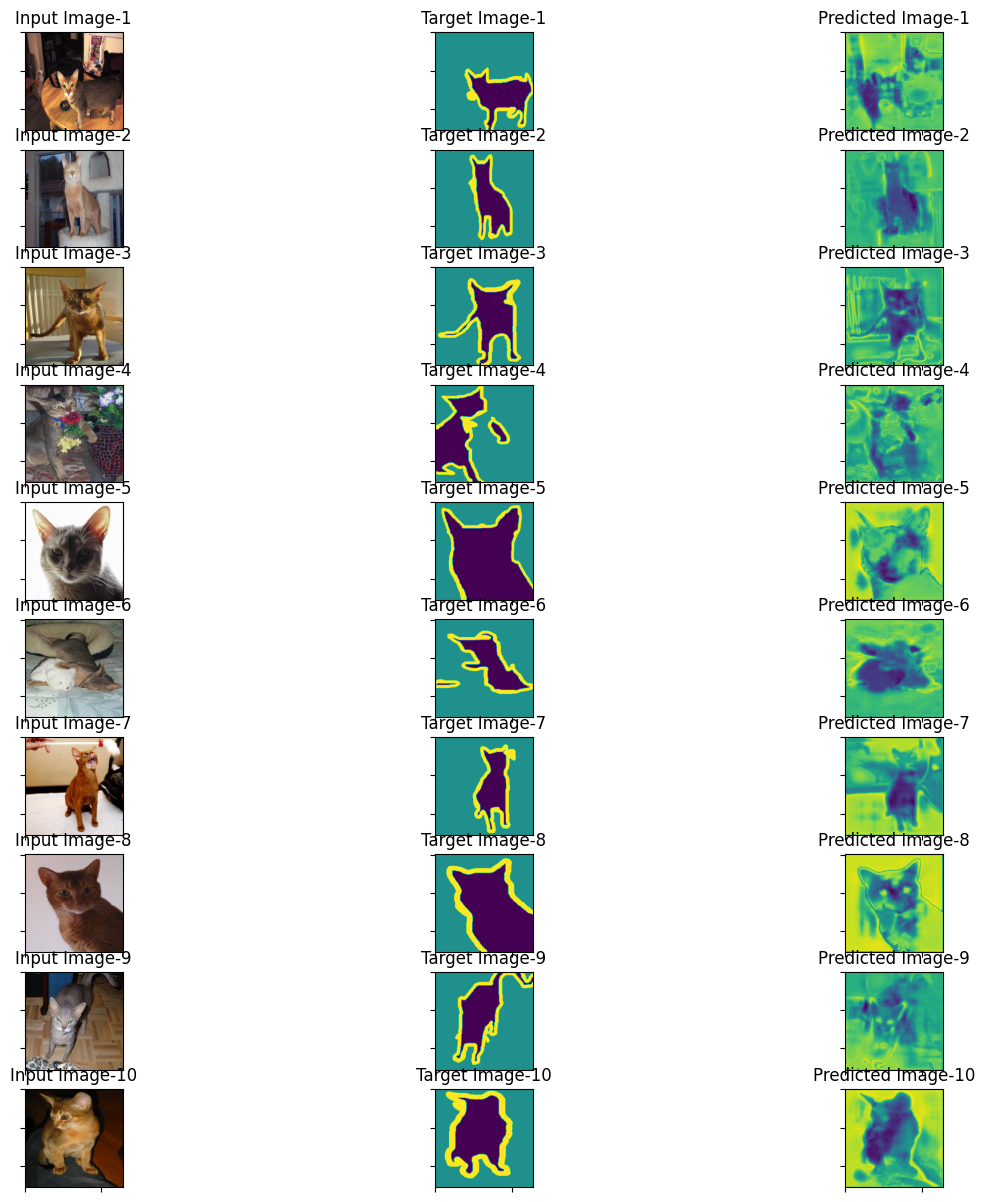

In [14]:
plot_unet_results(model=model, datamodule=datamodule, num_images=10)